In [368]:
import pandas as pd
import scipy as sp
import pickle
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matrixprofile import *
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
sns.set(rc={'figure.figsize':(20.7,8.27)})

             Date     Open     High      Low    Close   Volume  OpenInt
2000   1977-12-02   2.6936   2.7142   2.6936   2.6936   234491        0
2001   1977-12-05   2.6936   2.6936   2.6723   2.6723    47510        0
2002   1977-12-06   2.6723   2.6936   2.6098   2.6098   593893        0
2003   1977-12-07   2.6098   2.6309   2.5889   2.6098   159393        0
2004   1977-12-08   2.6098   2.6723   2.6098   2.6098   167056        0
...           ...      ...      ...      ...      ...      ...      ...
12069  2017-11-06  47.2000  47.6800  46.5300  47.2900  1725638        0
12070  2017-11-07  47.1100  47.2042  46.5400  46.9700  2168351        0
12071  2017-11-08  46.7300  46.7700  45.3700  45.8900  3347930        0
12072  2017-11-09  44.7100  44.7100  43.1100  43.3300  7671810        0
12073  2017-11-10  42.9300  44.4600  42.7500  43.0100  4463839        0

[10074 rows x 7 columns]


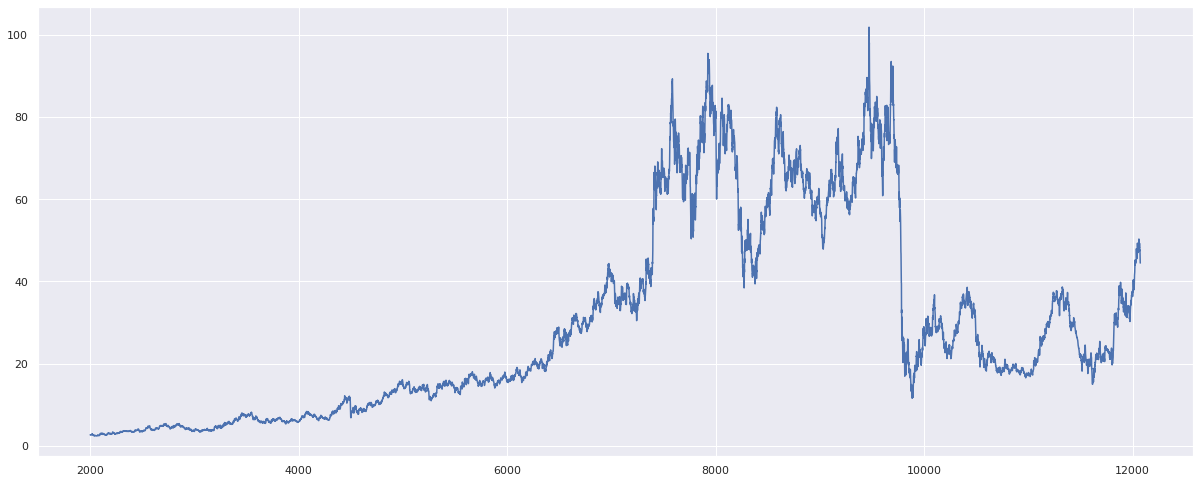

In [445]:
#Dataset https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
df = pd.read_csv('price-volume-data-for-all-us-stocks-etfs/Stocks/aa.us.txt', sep=",", header=0).iloc[2000:]
print(df)
plt.plot(df['High'])

In [446]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(df[['High']].values)
df_normalized = pd.DataFrame(scaler.transform(df[['High']].values)).dropna().reset_index(drop=True)

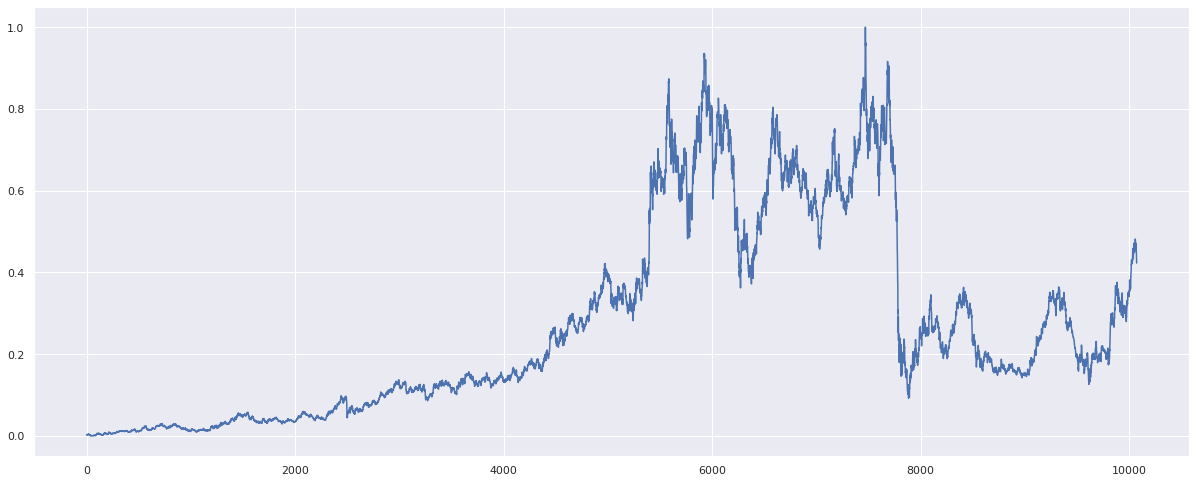

In [447]:
plt.plot(df_normalized)
plt.show()

#plt.plot(df_normalized_diff)

In [582]:
#Generate labels:
#TODO: Think about new labeling strategy
paa_length = 7
sensitivity = 0.5
epsilon = np.std(df_normalized.values.T[0])*sensitivity
labels = []
for i in range(0, len(df_normalized.values.T[0])-paa_length, paa_length):
    if (df_normalized.values.T[0][i:i+paa_length].mean() + epsilon*0.5 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [4.0] * paa_length #rise
    elif (df_normalized.values.T[0][i:i+paa_length].mean() + epsilon*0.375 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [3.0] * paa_length #rise
    elif (df_normalized.values.T[0][i:i+paa_length].mean() + epsilon*0.25 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [2.0] * paa_length #rise
    elif (df_normalized.values.T[0][i:i+paa_length].mean() + epsilon*0.125 < 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [1.0] * paa_length #rise
    elif (df_normalized.values.T[0][i:i+paa_length].mean() - epsilon*0.125 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-1.0] * paa_length #fall
    elif (df_normalized.values.T[0][i:i+paa_length].mean() - epsilon*0.25 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-2.0] * paa_length #fall
    elif (df_normalized.values.T[0][i:i+paa_length].mean() - epsilon*0.375 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-3.0] * paa_length #fall
    elif (df_normalized.values.T[0][i:i+paa_length].mean() - epsilon*0.5 > 
    df_normalized.values.T[0][i+paa_length: i+2*paa_length].mean()):
        labels += [-4.0] * paa_length #fall
    else:
        labels += [0.0] * paa_length #equal
    
    '''
    if df_normalized.values.T[0][i] + epsilon*0.5 < df_normalized.values.T[0][i+paa_length]:
        labels += [1.0] * paa_length #rise
    elif df_normalized.values.T[0][i] - epsilon*0.5 > df_normalized.values.T[0][i+paa_length]:
        labels += [-1.0] * paa_length #fall
    '''

#Get diff
df_normalized_diff = df_normalized #df_normalized.diff(paa_length).dropna()

#Shift labels
labels = labels[:-int(paa_length*0.5)]
df_normalized_diff = df_normalized_diff.iloc[int(paa_length*0.5):]

#Split
sz = df_normalized_diff.shape[0]
df_train = df_normalized_diff.iloc[0:int(sz*0.75)]
df_test = df_normalized_diff.iloc[int(sz*0.75):int(sz*0.875)]
df_valid = df_normalized_diff.iloc[int(sz*0.875):]

labels_train = labels[0:int(sz*0.75)]
labels_test = labels[int(sz*0.75):int(sz*0.875)]
labels_valid = labels[int(sz*0.875):]


#Find segements with homogeneous labeling for training
split = lambda df, chunk_size: np.array_split(df, len(df) // chunk_size + 1, axis=0)
segments_train = split(pd.DataFrame(labels_train).astype(int), paa_length)
segments_train_df = split(df_train, paa_length)
segments_train_homogeneous = []
segments_train_homogeneous_df = []
for index, segment in enumerate(segments_train):
    if segment[0].nunique() == 1 and segment.shape[0] == paa_length: #TODO Homogeneous length rmoved write that in paper
        segments_train_homogeneous.append(segment)
        segments_train_homogeneous_df.append(segments_train_df[index])
labels_train = pd.concat(segments_train_homogeneous, axis=0).values
df_train = pd.concat(segments_train_homogeneous_df, axis=0)


#Extract mtfs
m_length = paa_length 
max_motifs = 1024
radius = 7#int(paa_length*0.5)

def extract(data, m_length, max_motifs, radius):
    mp = matrixProfile.scrimp_plus_plus(data, m_length) #6 or 32
    mtfs, motif_d = motifs.motifs(data, mp, max_motifs=max_motifs, radius=radius)
    return mtfs, motif_d

#Select mtfs
def select(data, mtfs, motif_d, length, mode):
    sz = len([item for sublist in mtfs for item in sublist]) * length
    attr_vec = np.ndarray(shape=(sz, mode), dtype=float) #3
    count = 0
    tag = 1.0
    for i, motif in enumerate(mtfs):
        for index in motif:
            elem = np.array(data[index:index + length])
            for pos, x in enumerate(elem):
                attr_vec[count + pos][0] = x
                if mode == 6:
                    attr_vec[count + pos][0] = 0.0
                    attr_vec[count + pos][1] = tag #Add tag of found motif
                    attr_vec[count + pos][2] = elem.std() #Add std of found motif
                    attr_vec[count + pos][3] = sp.stats.skew(elem) #Add min of found motif
                    attr_vec[count + pos][4] = np.gradient(elem).mean() #Add max of found motif
                    attr_vec[count + pos][5] = motif_d[i] #Add motif distance

            count += length
        tag += 1.0

    attr_vec = pd.DataFrame(attr_vec)
    
    if mode == 1: #we are selecting relevant labels
        attr_vec = attr_vec.groupby(attr_vec.index // length).first() #try .agg(lambda x: x.value_counts().index[0]), aggregation by majority label
    if mode == 6: #then we are selecting relevant features
        attr_vec = attr_vec.groupby(attr_vec.index // length).mean()
    attr_vec = attr_vec.dropna()
    return attr_vec

mtfs, motif_d = extract(df_train.values.T[0], m_length, max_motifs, radius)
X_train = select(df_train.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_train = select(labels_train, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)
print(motif_d)

mtfs, motif_d = extract(df_test.values.T[0], m_length, max_motifs, radius)
X_test = select(df_test.values.T[0], mtfs, motif_d, m_length, mode=6).reset_index(drop=True)
y_test= select(labels_test, mtfs, motif_d, m_length, mode=1).astype(int).reset_index(drop=True)
print(motif_d)


[0.011477616401625229, 0.012747575676829766, 0.078431344828947, 0.08008675591682403, 0.08455759013329293, 0.08686395541051076, 0.09778227290110786, 0.09839937339302147, 0.11409026406914205, 0.11491417137166202, 0.1151593044308223, 0.11818911626046037, 0.1183284922840206, 0.11914880023402034, 0.11929237751548842, 0.11996854011189587, 0.1280995279253604, 0.13070269964435502, 0.14039973585308274, 0.1504650920258077, 0.1507684893507397, 0.15202676853484318, 0.15505330790925767, 0.15759884300772978, 0.17353958925536908, 0.1749832060125931, 0.18881985048765185, 0.18938353690054932, 0.19227253375262135, 0.21462039587711812, 0.21468300777233298, 0.22224924697080087, 0.22997852083258538, 0.2362695764341924, 0.2367247056879754, 0.23693485617923124, 0.23733370874897794, 0.24214922670398104, 0.24229497725782234, 0.24481192898758966, 0.25078947697007603, 0.25735563328333144, 0.26329057932533056, 0.2677187337706362, 0.28802056603992127, 0.32561308466013034, 0.3359552397246681, 0.3420859144515326, 0.

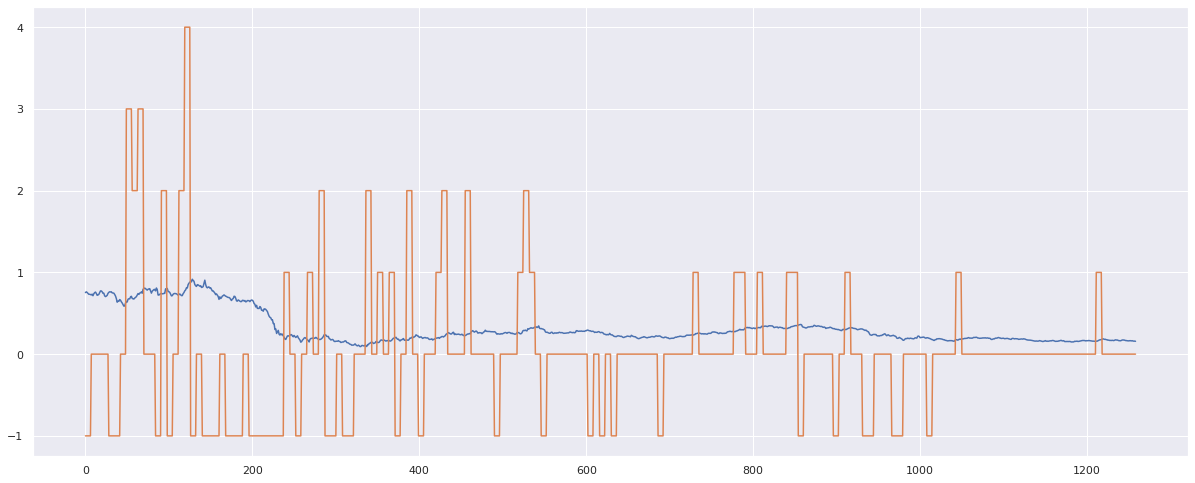

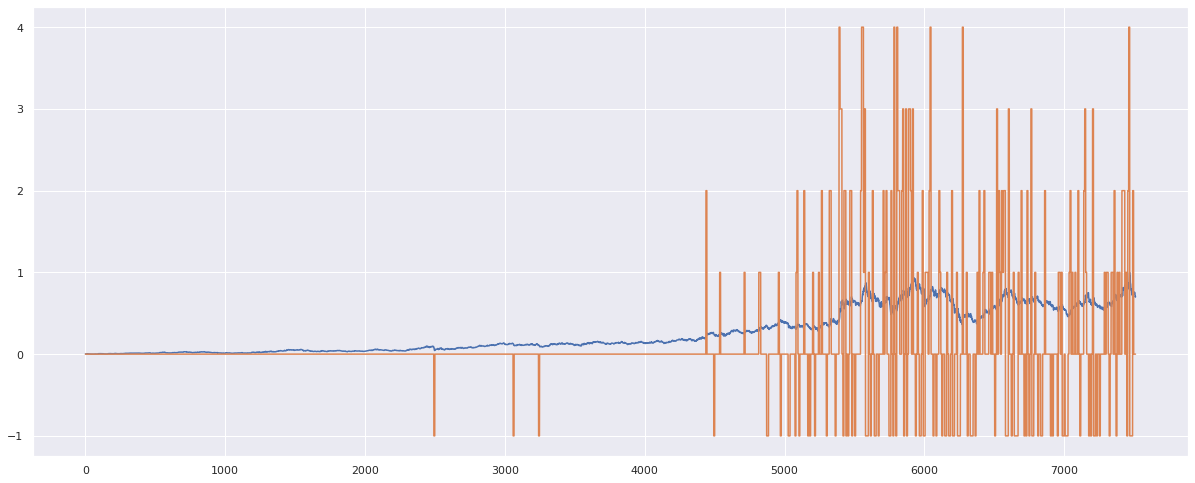

In [583]:
plt.plot(df_test.reset_index(drop=True))
plt.plot(labels_test)
plt.show()
plt.plot(df_train.reset_index(drop=True))
plt.plot(labels_train)
plt.show()

In [584]:
clf = RandomForestClassifier(random_state=0)
random_grid = {'bootstrap': [True, False],
               'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt', 'log2', None],
               'min_samples_leaf': [1, 2, 4, 6, 8],
               'min_samples_split': [2, 5, 10, 15, 20],
               'n_estimators': [25, 50, 130, 180, 230],
               'criterion': ['gini', 'entropy'],
               'class_weight' : ['balanced', 'balanced_subsample', None]
              }
clf = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
score = clf.score(X_test, y_test)
conf =confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print('True')
print(y_test.values.T[0])
print('Predicted')
print(y_pred)
print('Diff')
print((np.array(y_pred).T-np.array(y_test).T)[0])
print('\n')
print(conf)
print(score)
print(report)
print(clf.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   27.5s


True
[ 0  0  2  3  2  4  2  2  1  2  0  2  0  1  0  0  0  0  1  0  0  1  1  1
  1  1  0  0  0  0  0  0  0  0  0  0  1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1  0 -1 -1 -1  0  0  0 -1 -1  0  0 -1  0  0  0 -1  0  0  0  0 -1
  0 -1  0  0 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  1  1  0  0  1  2  1  2  0  0  2  1  0  0  0  0  0  0  1  0  0  1  0  0
  1  0  0 -1 -1 -1 -1 -1 -1  0 -1  0  0 -1  0  0  0  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  3  0  0  0 -1 -1  0  0
  2  0  0  0  0  0  0  0  0  0  0  0  2  4 -1  0  0 -1  0  0  0  0  0  1
  0  1  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  1 -1 -1  0  0  0  1  0  0
  0 -1  0  0  0  0  0]
Predicted
[ 2  2  2  2  3  2  2  2  2  2  1  2  1  2  0  0  0  0  1  0  0  1  1  1
  0  0  0  0  1  0  0  0  0  0  0  0  0 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0 -1
  0 -1  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  2
  2  0  0  0 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   47.6s finished
/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/home/lorenz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


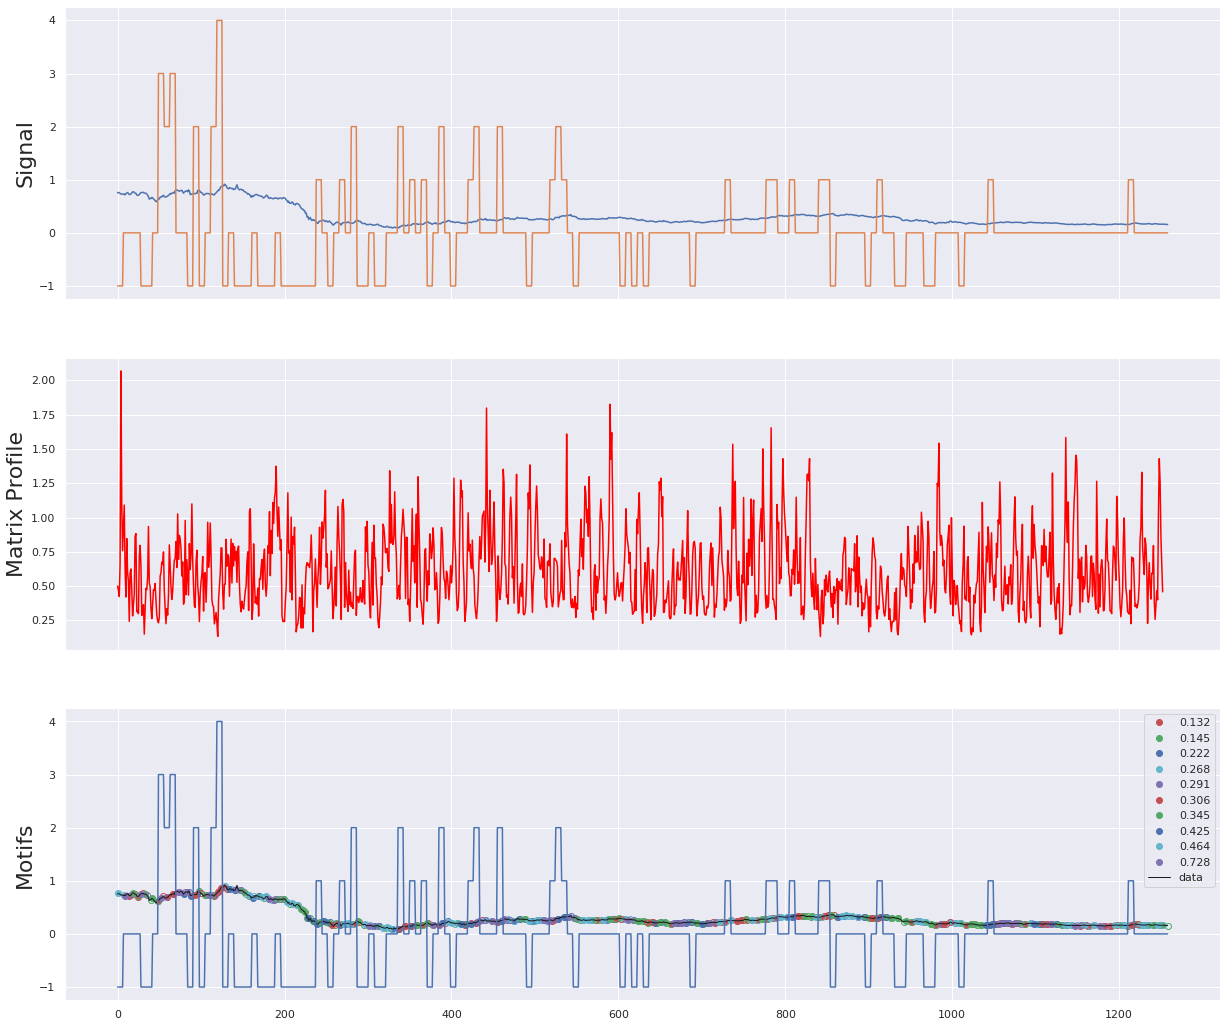

In [585]:
pattern = df_test.values.T[0]
def plot_motifs(mtfs, labels, ax):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

m=m_length
#Append np.nan to Matrix profile to enable plotting against raw data
mp = matrixProfile.scrimp_plus_plus(pattern, m_length) #6 or 32
mtfs, motif_d = motifs.motifs(pattern, mp, max_motifs=max_motifs, radius=radius)

mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

#Plot the signal data
fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20.7,18.27))
ax1.plot(np.arange(len(pattern)),pattern, label="Test Data")
ax1.plot(labels_test)
ax1.set_ylabel('Signal', size=22)

#Plot the Matrix Profile
ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
ax2.set_ylabel('Matrix Profile', size=22)

#Plot the Motifs
plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3)
ax3.plot(labels_test)
ax3.set_ylabel('Motifs', size=22)
#plt.xlim((0,100))
plt.show()

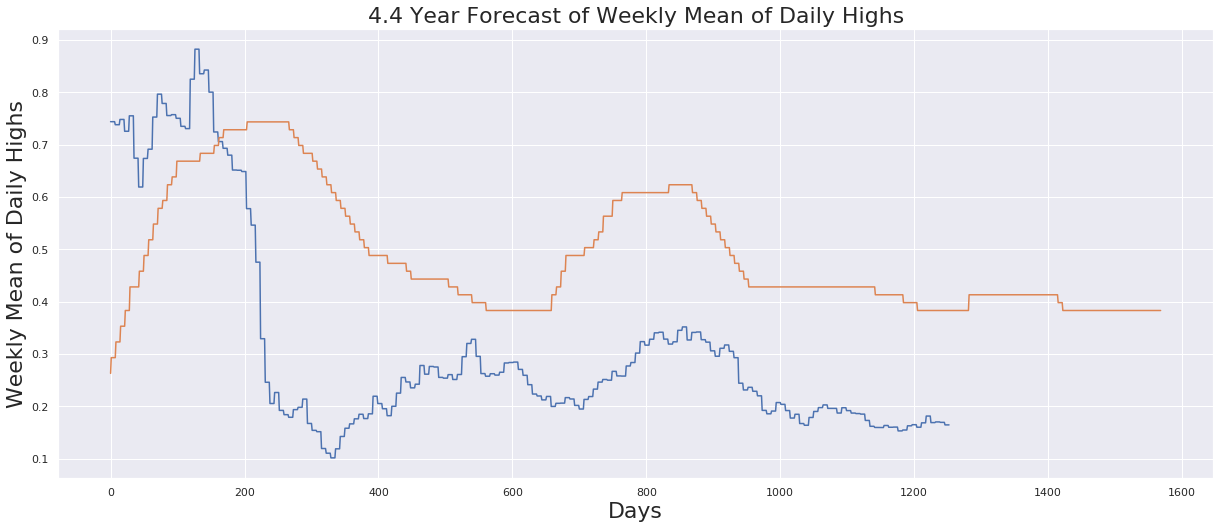

In [588]:
#Find prediction
labels_pred = []
means = []
pred = [df_train.values.T[0].mean()]
for i in range(0, len(y_pred)):
    if (i+1)*paa_length <= len(df_test.values.T[0]):
        means+=[df_test.values.T[0][i*paa_length:(i+1)*paa_length].mean()]*paa_length
     
    if y_pred[i] == 4.0:
        pred += [pred[-1] + epsilon*0.5]*paa_length
    elif y_pred[i] == 3.0:
        pred += [pred[-1] + epsilon*0.375]*paa_length
    if y_pred[i] == 2.0:
        pred += [pred[-1] + epsilon*0.25]*paa_length
    elif y_pred[i] == 1.0:
        pred +=[pred[-1] + epsilon*0.125]*paa_length
    elif y_pred[i] == -1.0:
        pred +=[pred[-1] - epsilon*0.125]*paa_length
    elif y_pred[i] == -2.0:
        pred +=[pred[-1] - epsilon*0.25]*paa_length
    elif y_pred[i] == -3.0:
        pred +=[pred[-1] - epsilon*0.375]*paa_length
    elif y_pred[i] == -4.0:
        pred +=[pred[-1] - epsilon*0.5]*paa_length
    else: pred +=[pred[-1]]*paa_length
    
plt.plot(means)
plt.plot(pred)
plt.title('4.4 Year Forecast of Weekly Mean of Daily Highs', size=22)
plt.ylabel('Weekly Mean of Daily Highs', size=22)
plt.xlabel('Days',size=22)
plt.show()